# 曆象推算
從[中央氣象局](http://www.cwb.gov.tw/V7/astronomy/calendar.htm#s1)我們可以查得曆象資料，包括24節氣、陰陽曆對照表、朔望月、日蝕月蝕。

我們知道，
* 太陽的黃經在15度的整數倍數的時候就是24節氣的日子，
* 太陽與月亮同一黃經的時候就是朔月的日子，太陽與月亮黃經相差180度的時候就是朔月的日子，
* 太陽、地球、月亮幾乎共線的時候會產生日蝕或月蝕。

所以，
* 只要知道太陽月亮在黃道座標系統中每一時刻的位置，就可以推算出24節氣、朔望月的時刻。
* 再加上知道陰曆置潤規則就可以得到陰陽曆對照表。
* 只要知道太陽月亮在任何座標系統中每一時刻的位置，就可以推算出日蝕月蝕。

後面，我們使用 Python 平台的 astropy 套件一一的加以推算。

## 24節氣與朔望月的計算
### 計算太陽與月亮的黃經
`astropy.coordinates.get_body('sun',t, ephemeris='jpl')`可以得到太陽在時刻t的位置(ICRS座標系統)。有了 ICRS 位置，以 `pos`為名，
可以轉換到黃道座標系統，事實上 `pos.transform_to(astropy.coordinates.GeocentricTrueEcliptic(equinox=t)).lon.deg` 就是太陽在黃道座標系統的黃經(單位：度)。

將前述的 'sun' 改成 'moon'，就可以得到月亮的黃經。將 'sun' 改成太陽系的其他行星就可得該行星的黃經。

將前面的 `.lon.deg` 改成 `.lat.deg` 就得到黃緯(單位：度)。


### 24節氣
我們知道，太陽的黃經等於15度的整數倍的時候就是24節氣的日子，0度的時候是春分，15度的時候是清明，其他依序為穀雨,立夏,小滿,芒種,夏至,小暑,
大暑,立秋,處暑,白露,秋分,寒露,霜降,立冬,小雪,大雪,冬至,小寒,大寒,立春,雨水,驚蟄。

用 sun(t) 代表太陽在時刻t的黃經度數，地球繞太陽逆時針旋轉，所以 sun(t) 是t的遞增函數，每一天大約增加 360/365.25度。
因為是太陽黃經為15度的時候，所以只要t日零時的黃經不超過15度而且t+1日零時的黃經大於15度，t日就是清明。
只要t時刻的黃經不超過15度而且下一秒的黃經大於15度，t時刻就是清明的時刻。

同理，可算得其他的節氣。

### 朔望月
我們知道，太陽的黃經等於月亮黃經的日子就是朔月日，太陽的黃經與月亮黃經相差180度就是朔月日。朔月日就是陰曆的初一。

用 moon(t) 代表月亮在時刻t的黃經度數，月亮繞地球也是逆時針，所以 moon(t) 也是遞增函數。又因為月亮黃經每天約增加360/29.5度，
黃經增加的數度比太陽快很多，所以 moon(t)-sun(t) 是t的遞增函數。

所以只要某日零時(用t表示)的moon(t)-sun(t)不超過180度而且moon(t+1日)-sun(t+1日)大於180度，該日就是望月日。

同理，可算出朔月日、上弦日與下弦日。

### CCTerm
函數 CCTerm 可以用來算節氣與朔望月。



In [2]:
from astropy.time import Time,TimeDelta
from astropy.coordinates import get_sun,FK5,PrecessedGeocentric,get_body
from astropy import coordinates as coord
from astropy import constants as const
from astropy.coordinates import SkyCoord
import math
import numpy as np


In [3]:
jieqinames=["春分","清明","穀雨","立夏","小滿","芒種","夏至","小暑","大暑","立秋",
              "處暑","白露","秋分","寒露","霜降","立冬","小雪","大雪","冬至","小寒","大寒","立春","雨水","驚蟄"]
moonshapenames=['朔月','上弦','望月','下弦']
def CCTerm(start,end,type):
    eighthours=TimeDelta(8*3600,format='sec')
    def termtime(daytime,daytime2,code,unit='hour'):
        if unit=='hour':
            times=daytime+np.linspace(0.,1.,25)*(daytime2-daytime)
        elif unit=='minute':
            times=daytime+np.linspace(0.,1.,61)*(daytime2-daytime)
        else:
            times=daytime+np.linspace(0.,1.,61)*(daytime2-daytime)
        gmttimes=times-eighthours
        if type=='jieqi':
            diflongitudes=get_body('sun', gmttimes,  ephemeris='jpl').\
                transform_to(coord.GeocentricTrueEcliptic(equinox=gmttimes)).lon.deg
        else:
            sunlongitudes=get_body('sun', gmttimes,  ephemeris='jpl').\
                transform_to(coord.GeocentricTrueEcliptic(equinox=gmttimes)).lon.deg
            moonlongitudes=get_body('moon', gmttimes,  ephemeris='jpl').\
                transform_to(coord.GeocentricTrueEcliptic(equinox=gmttimes)).lon.deg
            diflongitudes=(moonlongitudes-sunlongitudes)%360
        difcode=diflongitudes // sec
        difcode=[int(difcode[i]) for i in range(len(difcode))]
        for i in range(len(difcode)-1):
          if difcode[i+1]!=code:
            if unit=='hour':
              return termtime(times[i],times[i+1],code,"minute")
            else:
              if unit=='minute':
                return termtime(times[i],times[i+1],code,"second")
              else:
                return ((code+1) % (360//sec),(times[i]+0.5*(times[i+1]-times[i])).value)
        return (-1,"")

    start=Time(Time(start,out_subfmt='date').iso)
    end=Time(Time(end,out_subfmt='date').iso)
    daycount=int(round((Time(end)-Time(start)).value))
    # print(start,end,daycount)
    # print(daycount)
    times=Time(start)+np.linspace(0.,1.,daycount+1)*(end-start+TimeDelta(3,format='sec')) # 考量潤秒，故加上3秒
    times=Time(Time(times,out_subfmt='date').iso)
    gmttimes=times-TimeDelta(8*3600,format='sec')
    if type=='jieqi':
        diflongitudes= get_body('sun', gmttimes,  ephemeris='jpl').\
            transform_to(coord.GeocentricTrueEcliptic(equinox=gmttimes)).lon.deg
        sec=15
    else:
        sunlongitudes=get_body('sun', gmttimes,  ephemeris='jpl').\
            transform_to(coord.GeocentricTrueEcliptic(equinox=gmttimes)).lon.deg
        moonlongitudes=get_body('moon', gmttimes,  ephemeris='jpl').\
            transform_to(coord.GeocentricTrueEcliptic(equinox=gmttimes)).lon.deg
        diflongitudes=(moonlongitudes-sunlongitudes)%360
        sec=90
    res=[]
    difcode=diflongitudes // sec
    difcode=[int(difcode[i]) for i in range(len(difcode))]
    for i in range(len(difcode)-1):
      if difcode[i]!=difcode[i+1]:
        res.append(termtime(times[i],times[i+1],difcode[i],'hour'))
    return res



CCTerm 函數中， 
* start 是起始日，end 是結束日，
* `type='jieqi'` 時算節氣；`'moon'`時算朔望月，
* 函數值為一個清單(list)，清單裡的元素是序對 (code,time)，code為節氣/朔望碼，time 為對應的時刻，
* 節氣碼0,1,2,...,23分別對應春分,清明,穀雨,立夏,小滿,芒種,夏至,小暑,
大暑,立秋,處暑,白露,秋分,寒露,霜降,立冬,小雪,大雪,冬至,小寒,大寒,立春,雨水,驚蟄；朔望碼0,1,2,3分別對應朔月,上弦,望月,下弦。

例如，`CCTerm('2017-1-1','2018-3-1','jieqi')` 會算出2017年1月1日零時至2018年3月1日零時之間的所有節氣的時刻(準確到秒)。與中央氣象局的[公告](http://www.cwb.gov.tw/V7/astronomy/cdata/2017cal.pdf)相比較，完全相符(中央氣象局只公告到分鐘)。


In [4]:
jieqi=CCTerm('2017-1-1','2018-3-1','jieqi')
for code,time in jieqi:
    print(jieqinames[code]+' '+time)

小寒 2017-01-05 11:55:44.500
大寒 2017-01-20 05:23:36.500
立春 2017-02-03 23:34:03.500
雨水 2017-02-18 19:31:19.500
驚蟄 2017-03-05 17:32:43.500
春分 2017-03-20 18:28:37.500
清明 2017-04-04 22:17:19.500
穀雨 2017-04-20 05:27:00.500
立夏 2017-05-05 15:31:02.500
小滿 2017-05-21 04:30:55.500
芒種 2017-06-05 19:36:36.500
夏至 2017-06-21 12:24:09.500
小暑 2017-07-07 05:50:41.500
大暑 2017-07-22 23:15:21.500
立秋 2017-08-07 15:39:59.500
處暑 2017-08-23 06:20:13.500
白露 2017-09-07 18:38:36.500
秋分 2017-09-23 04:01:47.500
寒露 2017-10-08 10:22:08.500
霜降 2017-10-23 13:26:40.500
立冬 2017-11-07 13:37:49.500
小雪 2017-11-22 11:04:38.500
大雪 2017-12-07 06:32:38.500
冬至 2017-12-22 00:27:56.500
小寒 2018-01-05 17:48:44.500
大寒 2018-01-20 11:09:01.500
立春 2018-02-04 05:28:29.500
雨水 2018-02-19 01:18:00.500


又如， `CCTerm('2017-1-1','2018-3-1','moon')` 會算出2017年1月1日零時至2018年3月1日零時之間的所有朔望月的時刻(準確到秒)。與中央氣象局的[公告](http://www.cwb.gov.tw/V7/astronomy/cdata/2017cal.pdf)相比較，只有9月28日的上弦時刻差了3秒(中央氣象局只公告到分鐘)。


In [5]:
darkmoon=CCTerm('2017-1-1','2018-3-1','moon')
for code,time in darkmoon:
    print(moonshapenames[code]+' '+time)


上弦 2017-01-06 03:47:01.500
望月 2017-01-12 19:33:58.500
下弦 2017-01-20 06:13:23.500
朔月 2017-01-28 08:07:00.500
上弦 2017-02-04 12:18:56.500
望月 2017-02-11 08:32:50.500
下弦 2017-02-19 03:33:03.500
朔月 2017-02-26 22:58:22.500
上弦 2017-03-05 19:32:26.500
望月 2017-03-12 22:53:47.500
下弦 2017-03-20 23:58:06.500
朔月 2017-03-28 10:57:13.500
上弦 2017-04-04 02:39:28.500
望月 2017-04-11 14:08:06.500
下弦 2017-04-19 17:56:40.500
朔月 2017-04-26 20:16:08.500
上弦 2017-05-03 10:46:55.500
望月 2017-05-11 05:42:28.500
下弦 2017-05-19 08:32:44.500
朔月 2017-05-26 03:44:29.500
上弦 2017-06-01 20:42:08.500
望月 2017-06-09 21:09:32.500
下弦 2017-06-17 19:32:42.500
朔月 2017-06-24 10:30:44.500
上弦 2017-07-01 08:51:05.500
望月 2017-07-09 12:06:32.500
下弦 2017-07-17 03:25:41.500
朔月 2017-07-23 17:45:36.500
上弦 2017-07-30 23:23:03.500
望月 2017-08-08 02:10:35.500
下弦 2017-08-15 09:15:06.500
朔月 2017-08-22 02:30:12.500
上弦 2017-08-29 16:12:56.500
望月 2017-09-06 15:02:46.500
下弦 2017-09-13 14:25:03.500
朔月 2017-09-20 13:29:53.500
上弦 2017-09-28 10:53:27.500
望

## 農曆的計算
我國的農曆基本上是陰陽合曆。陰曆的月以月相為基礎，新月的時候就是初一。太陽與月亮落在同一黃經的那一天就是新月日(朔月日)，那天就是陰曆初一。一個月有時29天，有時30天，完全決定於兩次新月日之間相差29天還是30天。

陽曆年有365或366 天，約相當於12.5個陰曆月，要維持一年有12個月名並且大年初一(陰曆一月一日)是在農閒的冬季，閏月的設置是一個可能的方法。一年有時有12個陰曆月，有時13個陰曆月，多出來的一個月叫閏月。知道了安排閏月的規矩，就可以製作農曆。

農曆基本上需要符合農作的需要，農作與天氣息息相關，天氣在一年中的循環形成春夏秋冬。

地球繞太陽一圈需時365.2422天。用地心赤道坐標系統的角度來看，太陽在春分與秋分兩次落在赤道平面上。一次在3月份，那時太陽從赤道平面下方跑到赤道平面上方，另一次在9月份，那時太陽從赤道平面下方跑到赤道平面上方。3月份的那一刻叫春分，9月份的那一刻叫秋分。太陽在赤道平面上方的時候，北半球較熱，南半球較冷。

太陽在黃道面上，一陽曆年繞行地球一圈，以春分時太陽的位置為基準，每繞行15度得一節氣，分別是春分，清明,穀雨,立夏,小滿,芒種,夏至,小暑,大暑,立秋,處暑,白露,秋分,寒露,霜降,立冬,小雪,大雪,冬至,小寒,大寒,立春,雨水,驚蟄。太陽位於黃經0度時是春分，15度時是清明，餘此類推。位於黃經30度整數倍的節氣叫做中氣，換句話說，春分,穀雨,小滿,夏至,大暑,處暑,秋分,霜降,小雪,冬至,大寒,雨水等為中氣。節氣與太陽的位置關係密切，太陽是地球能量的主要來源，所謂春耕、夏耘、秋收、冬藏道盡了農作與太陽之間的關係。先人的對於農時的經驗，大致用節氣來表示。

### 節氣
中央氣象局的[天文常識系列](http://www.cwb.gov.tw/V7/knowledge/announce/PDFfile/astronomy3.pdf)提到節氣
```
節氣的定法有兩種，古時候使用的稱為平氣法，就是把冬至到下一個冬至平分為24等分，每一節氣都是15天多。從清初時憲曆(西元1645年)起，節氣的推算改為定氣法，自春分點開始，太陽在黃道上每視行15度定一個節氣，節氣間隔的時間並不等長。
```
### 陰曆的月份
平均起來一個陰曆月約有29.5天，而一年有365.2422天，12個陰曆月比一年短少約11天。為了維持一年有12個月份，我國用閏月的方式來解決。大致上，每隔約三年，設置一個月為閏月，其月份與前一個月同。假如前一個月是8月而這個月是閏月，這個月叫潤8月，而下個月叫9月。

哪一個月的初一是春節？哪一個月要閏月？

中央研究院劉智漢在[這裡](http://sinocal.sinica.edu.tw/luso_v2.html)提到歲首的問題：
```
自漢武帝太初元年（西元前104年）改曆以來，至今大都採用夏代的建寅制，即自冬至所在月份起算的第三個月為正月
```
因此，冬至所在的陰曆月為11月。

### 置潤規矩
Aslaksen的[文章](http://www.math.nus.edu.sg/aslaksen/calendar/cal.pdf)列出了安置月份與置潤的原則。條列如下：

* 計算時間時以東經120度為基準
* 每天的起算時間為午夜零時
* 新月那天為陰曆初一
* 一歲的開始為冬至的那一刻所在的日子，以下一個冬至日的前一天為最終日。用歲來稱呼，與大年初一開始的年有所區別。冬至日的陰曆月訂為11月
* 若一歲裡包含了完整的12個陰曆月，這一歲叫潤歲。在潤歲裡，第一個沒有中氣的月份必須閏月

根據這些原則，下面實作了函數PrintCCalender(year)。用PrintCCalender(2017)，我們算出2017年陰陽曆的對應，得到2017年潤6月，與中央氣象局的資料相符合。



In [6]:
Cnumber=['一','二','三','四','五','六','七',
               '八','九','十','十一','十二']

def _CCalendar(year):
    oneday=TimeDelta(1, format='jd')
    limits=CCTerm(str(year-1)+'-12-1',str(year+1)+'-1-1','jieqi')
    limits=[data for data in limits if data[0]==18] # 冬至
    darkmoon=CCTerm(Time(limits[0][1])+oneday,Time(limits[1][1])+oneday,'moon')
    
    darkmoon=[m[1] for m in darkmoon if m[0]==0]  # 朔月
    
    res=[]
    
    if len(darkmoon)<13:
        for i in range(12):
            j=(i+12)%12
            if j==0:
                j=12
            res.append((j,darkmoon[i]))
    else:
        add=False
        mnumber=12
        for i in range(12):
            js=CCTerm(Time(darkmoon[i]),Time(darkmoon[i+1]),'jieqi')
            #print(js)
            js=[d for d in js if d[0]%2==0] # 中氣
            #print(js)
            if add==False and len(js)==0 :
                res.append((mnumber-1+0.1,darkmoon[i])) # 有小數點代表閏月
                add=True
            else:
                res.append((mnumber,darkmoon[i]))
                mnumber=mnumber+1
                if mnumber==13:
                    mnumber=1
        res.append((mnumber,darkmoon[12]))
    return(res)
def CCalendar(year):
    res=_CCalendar(year)+_CCalendar(year+1)
    return([m for m in res if m[1]>=str(year)+'-01-01' and m[1]<str(year+1)+'-01-01'])

def PrintCCalender(year):
    res=CCalendar(year)
    for m in res:
        name=Cnumber[int(m[0])-1]+'月初一'
        if int(m[0])!=m[0]:
            name='潤'+name
        print(name+','+m[1])
    



In [7]:
PrintCCalender(2017)

一月初一,2017-01-28 08:07:00.500
二月初一,2017-02-26 22:58:22.500
三月初一,2017-03-28 10:57:13.500
四月初一,2017-04-26 20:16:08.500
五月初一,2017-05-26 03:44:29.500
六月初一,2017-06-24 10:30:44.500
潤六月初一,2017-07-23 17:45:36.500
七月初一,2017-08-22 02:30:12.500
八月初一,2017-09-20 13:29:53.500
九月初一,2017-10-20 03:12:04.500
十月初一,2017-11-18 19:42:06.500
十一月初一,2017-12-18 14:30:22.500


## 日蝕與月蝕
月食是月亮落在地球的陰影裡，日蝕是地球落在月亮的陰影裡，陰影有本影與半影之分。

見下圖，將太陽S、遮蔽球O(地球/月亮)與被遮球T(月亮/地球)的球心放在X-Y平面上，圓S,圓O分別為太陽與遮蔽球跟X-Y平面相交的圓。$PC_1,PC_2$
為兩圓的內公切線，$UC_1,UC_2$為外公切線，$\alpha$為$\angle C_1UO$，$\beta$為$\angle C_1PO$。
$C_1U,C_2U$繞$UO$旋轉所得的圓錐落在U點左側的部分為偽本影；U點右側O球左側的部分是本影，U是本影的頂點，OU的長度叫做本影長。
半影區則為$C_1PC_2$繞$PO$旋轉所得圓椎落在O球左側且不屬於本影及偽本影的區域。

在遮蔽球左側已經滿足$\angle QPO < \beta$的點 $Q$，
* 若 $\angle QUO < \alpha$，則 $Q$在本影區；
* 若 $\alpha<\angle QUO<\pi-\alpha$，則 $Q$在半影區。
* 若 $\angle QUO > \pi-\alpha$，則 $Q$在偽本影區；

就日食來說，觀測地$Q$落在本影區看到日全食，落在偽本影區看到日環食，落在半影區看到日偏食。

從半影圓錐頂點P觀看球T的視角之半用$\delta$表示，從本影圓錐頂點U點觀看球T的視角之半用$\gamma$表示。

我們知道，$\angle TPO = \beta+\delta$ 的時候，被遮球與半影圓錐外切。所以，
假設球T在球O左側且已經滿足$\angle TPO < \beta+\delta$，
* 若 $\beta-\delta<\angle TPO  $，則球T局部落進陰影區
* 若 $\angle TPO < \beta-\delta$，則球T全部落進陰影區，此時

  * 若 $\alpha+\gamma< \angle TUO<\pi-\alpha-\gamma$，則球T全部落進半影區
  * 若 $\alpha-\gamma<\angle TUO<\alpha+\gamma$，則球T局部落進本影區
  * 若 $\angle TUO<\alpha-\gamma$，則T球全部落進本影區
  * 若 $\pi-\alpha-\gamma<\angle TUO<\pi-\alpha+\gamma$，則球T局部落進偽本影區
  * 若 $\pi-\alpha+\gamma<\angle TUO$，則T球全部落進偽本影區
註：當U在T求內部的時候，要另外考慮。

就月蝕來說，月球落在地球的半影區或偽本影區為半影月蝕，落在本影區為本影月蝕，整個月球落在本影區為月全蝕，部分落在本影區為月偏食。

有了這些概念，立用太陽與月球隨時間改變的座標(地心為原點的座標系統)，以及地球、太陽、月亮的半徑等資料，可以推算出何時日時、何時月時以及食相。

<img align="left" style="padding-right:10px;" src="lunar.png" width="600">

* 地球會不會跑到月球的偽本影區？應該會，否則我們不會有日環食的歷史紀錄。
* 地球會不會完全落在本影區？可能不會，因為沒聽過白天的半個地球上的人們同時看到日全食。
* 月球會不會跑到地球的偽影區？

若圓O,S的半徑用$r_o,r_s$表示，O,S間的距離用$d$表示，O,U間的距離(本影長)用$d_u$表示，O,P間的距離用$d_p$表示。因為
$\frac{d_u}{r_o}=\frac{d_u+d}{r_s}$，所以$d_u=\frac{dr_o}{r_s-r_o}$。因為 $\frac{d_p}{r_o}=\frac{d-d_p}{r_s}$，所以
$d_p=\frac{dr_o}{r_s+r_o}$。


我們知道，地球赤道半徑 $r_e=6378.1$公里,月亮半徑 $r_m=1737.4$公里, 太陽半徑 $r_s=695700$公里，基本上不隨時間改變。

日地距、日月距、月地距會隨時間改變，但可用astropy裡面的get_body函數來獲得。

下面用du函數計算本影長，miscplot利用du的計算繪出一些圖形幫助了解處境。

In [8]:
import astropy.constants as const
from astropy.coordinates import get_body, solar_system_ephemeris
from astropy.time import Time
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
r_s=const.R_sun.to('km')
r_e=const.R_earth.to('km')
r_m=1737.4*u.km
def miscplot(year,type='viewangle'):
    # 概算月亮一年中的最大視角
    times=Time(str(year)+'-01-01')+np.linspace(0.,1.,366)*(Time(str(year+1)+'-1-1')-Time(str(year)+'-1-1'))
    with solar_system_ephemeris.set('jpl'):
        moons=get_body('moon',times)
        suns=get_body('sun',times)
    
    moonangles=np.degrees(2*np.arcsin(r_m/(moons.distance.to('km')-r_e)))
    sunangles=np.degrees(2*np.arcsin(r_s/suns.distance.to('km')))
    if type=="viewangle":
        plt.plot(times.jyear,moonangles,label="app. angle of moon")
        plt.plot(times.jyear,sunangles,label="app. angle of sun")
        plt.title("apparent angle of sun and moon")
        plt.legend()
        #print("日地距",np.min(moons.distance.to('km').value),np.max(moons.distance.to('km').value))

    if type=="moon":
        plt.plot(times.jyear,du("moon",moons,suns),label="du")
        plt.plot(times.jyear,moons.distance.to('km').value,label="distance to moon")
        plt.title("moom shodow")
        plt.legend()
        #print(du("moon",moons,suns))
    if type=="earth":
        plt.plot(times.jyear,du("earth",moons,suns),label="du")
        plt.plot(times.jyear,moons.distance.to('km').value,label="distance to moon")
        plt.title("earth shodow")
        plt.legend()
    plt.show()
        
def du(obj,moons,suns):
    rs=r_s.value
    if obj=='moon':
        ro=r_m.value
        dso=np.linalg.norm((moons.cartesian.xyz-suns.cartesian.xyz).to('km'),axis=0)
    else:
        ro=r_e.value
        dso=suns.distance.to('km').value
    return ro/(rs-ro)*dso

def dp(obj,moons,suns):
    rs=r_s.value
    if obj=='moon':
        ro=r_m.value
        dso=np.linalg.norm((moons.cartesian.xyz-suns.cartesian.xyz).to('km'),axis=0)
    else:
        ro=r_e.value
        dso=suns.distance.to('km').value
    return ro/(rs+ro)*dso

# print("月影長",147095000*r_m/(r_s-r_m),152100000*r_m/(r_s-r_m))
# print("地影長",147095000*r_e/(r_s-r_e),152100000*r_e/(r_s-r_e))

# print("日視角",np.degrees(2*np.arcsin(r_s.value/152100000)),np.degrees(2*np.arcsin(r_s.value/147095000)))
# print("月視角",np.degrees(2*np.arcsin(r_m.value/405696)),np.degrees(2*np.arcsin(r_m.value/363104)))

用 miscplot(2017,"viewangle") 指令劃出2017年太陽與月亮的視角隨時間變化的狀況。
由圖中可以了解，當三球接近共線，月球在太陽與地球之間，月球視角大於太陽視角且的時侯發生日食，有些地方可看到日全食；月球視角小於太陽視角的時侯發生日食，有些地方可能看到日環食。

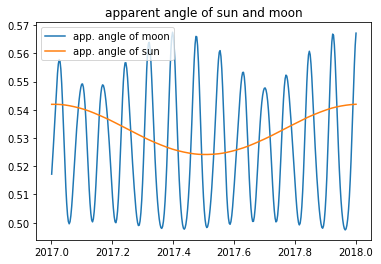

In [9]:
miscplot(2017,"viewangle")

用 miscplot(2017,"moon") 畫出2017年內月球本影長度du以及日地距的變化。發生日食的時侯，若日地距大於du，有些地方會看到日環食；若日地距小於du，有些地方會看到日全食；若日地距與du的差距小於地球半徑，在那一次的日食期間，可能有些地方日偏食，有些地方日環食，有些地方日全蝕。


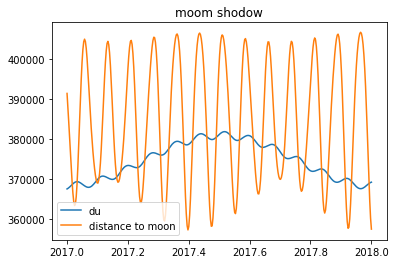

In [10]:
miscplot(2017,"moon")

用 miscplot(2017,"earth") 畫出2017年內地球本影長度du以及日地距的變化。可以看到du遠遠大於日地距，所以月球不可能跑到地球的偽本影區。

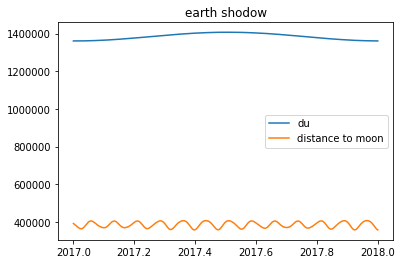

In [11]:
miscplot(2017,"earth")

下面要用函數SolarEclipse算出日食的時刻，用函數LunarEclipses算出月食的時刻。
https://eclipse.gsfc.nasa.gov/eclipse.html

In [27]:
# http://eclipse.gsfc.nasa.gov/eclipse.html 可查到歷年的日蝕月蝕的資料
oneminute=TimeDelta(60, format='sec')
eighthours=TimeDelta(8*3600,format='sec')
onesecond=TimeDelta(1, format='sec')
def separation(a,b):
    """a,b兩向量的夾角"""
    val=a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b))
    #if val>1.0:
    #    val=1.0
    #if val< -1.0:
    #    val= -1.0
    return(math.acos(val))
def ShadowCone(s,rs,o,ro,asin):
    o2s=s-o
    #dso=np.array([np.linalg.norm(x) for x in o2s])
    dso=np.linalg.norm(o2s,axis=1)
    sodir=np.array([-o2s[i]/dso[i] for i in range(len(o2s))])
    #sodir=np.diag(1.0/dso).dot(-o2s) ##### inefficient
    du=ro/(rs-ro)*dso
    ucenter=np.array([o[i]+du[i]*sodir[i] for i in range(len(o))])
    #ucenter=o+np.diag(du).dot(sodir) ##### inefficient
    #uarc=np.array([math.asin(rs/(dso[i]+du[i])) for i in range(len(s))])
    if asin:
        #uarc=np.array([math.asin(ro/du[i]) for i in range(len(s))])
        uarc=np.arcsin(ro/du)
    else:
        uarc=ro/du
    dp=ro/(rs+ro)*dso
    #parc=np.array([math.asin(rs/(dso[i]-dp[i])) for i in range(len(s))])
    if asin:
        #parc=np.array([math.asin(ro/dp[i]) for i in range(len(s))])
        parc=np.arcsin(ro/dp)
    else:
        parc=ro/dp
    pcenter=np.array([o[i]-dp[i]*sodir[i] for i in range(len(o))])
    #pcenter=o-np.diag(dp).dot(sodir) ##### inefficient
    return((ucenter,pcenter,uarc,parc,sodir))

codedict= {'O': '全在光亮區','H':'部分在半影區', 'F': '部分在本影區', 'G': '全在本影區','P':'部分在半影區',
           'D':'全在偽本影','C':'部分在偽本影'}

def Region(S,O,T,rt,Ucenter,Pcenter,uarc,parc,SOdir):
    res=[]
    for i in range(len(T)):
        if (T[i]-O[i]).dot(SOdir[i])<=0:
            res.append('O')    # O 代表光亮區
            continue
        vp=T[i]-Pcenter[i]
        ptarc=math.asin(rt/np.linalg.norm(vp))   # 從 P 看標的球圓盤T的視角之半, delta
        psep=separation(T[i]-Pcenter[i],SOdir[i]) # \angle TPO
        if psep>parc[i]+ptarc: # TPO>beta+delta
            res.append('O')   # psep>parc[i]+ptarc 代表標的球完全落在光亮區
            continue
        vu=T[i]-Ucenter[i]
        dist=np.linalg.norm(vu)
        if vu.dot(SOdir[i])<=0:  # 
            if dist<=rt:         # 本影頂點在球T內部
                res.append('F')  # 球T與本影區有重疊
                continue
            utarc=math.asin(rt/dist) # gamma
            usep=separation(vu,-SOdir[i]) #usep=angle TUO,alpha=uarc[i]
            if usep<= uarc[i]-utarc: # TUO<=alpha-gamma
                res.append('G')  # 球T完全進入本影區
            elif usep<= uarc[i]+utarc: # alpha-gamma<TUO<=alpha+gamma
                res.append('F')  # 球T部分落在本影區
            else:               # alpha+gamma < TUO
                res.append('P')  # 球T落在半影區
            continue
        else:                    # 
            if dist<=rt:         # 本影頂點在球T內部
                res.append('F')  # 球T與本影區有重疊
                continue
            utarc=math.asin(rt/dist) #gamma
            usep=separation(vu,SOdir[i]) #pi-TUO
            if usep<= uarc[i]-utarc:  # pi-TUO < alpha-gamma , TUO>pi-alpha+gamma
                res.append('D')  # 球T全部落在偽本影
            elif usep<= uarc[i]+utarc: # alpha-gamma<pi-TUO < alpha+gamma, pi-alpha-gamma< TUO <pi-alpha+gamma
                res.append('C')  # 球T局部落在偽本影
            else:                # pi-TUO>alpha+gamma, TUO<pi-alpha-gamma
                res.append('P')  # 球T全部落在半影區
            continue
    return(res)  

def EarthRegion(times,asin):
    gmttimes=times-eighthours
    sun=get_body('sun', gmttimes,  ephemeris='jpl')
    moon=get_body('moon', gmttimes,  ephemeris='jpl')
    earth=get_body('earth', gmttimes,  ephemeris='jpl')
    rs=const.R_sun.to('km').value
    re=const.R_earth.to('km').value
    ro=1737.1
    sunpos=np.transpose(np.array([sun.cartesian.x.value,
                                  sun.cartesian.y.value,sun.cartesian.z.value]))
    moonpos=np.transpose(np.array([moon.cartesian.x.value,
                                  moon.cartesian.y.value,moon.cartesian.z.value]))
    earthpos=np.zeros((len(sunpos),3))
    Ucenter,Pcenter,uarc,parc,SOdir=ShadowCone(sunpos,rs,moonpos,ro,asin)
    return(Region(sunpos,moonpos,earthpos,re,Ucenter,Pcenter,uarc,parc,SOdir))
    

def SolarEclipseOne0(start,end,asin=False):
    #print((Time(end)-Time(start)).value)
    minutecount=int(np.ceil((Time(end)-Time(start)).value*1440))
    times=Time(start)+np.linspace(0.,1.,minutecount+1)*(Time(end)-Time(start))
    regions=EarthRegion(times,asin)
    #print(times[0],regions[0])
    for i in range(len(times)-1):
        if regions[i]!=regions[i+1]:
            newsymbol=regions[i+1]
            oldsymbol=regions[i]
            sectimes=times[i]+onesecond*np.linspace(0,60,61)
            secregions=EarthRegion(sectimes,asin)
            for j in range(61):
                j1=60-j
                if secregions[j1]!=newsymbol:
                    print(sectimes[j1],newsymbol)
                    break
def SolarEclipseOne(start,end,asin=False):
    #print((Time(end)-Time(start)).value)
    minutecount=int(np.ceil((Time(end)-Time(start)).value*1440))
    times=Time(start)+np.linspace(0.,1.,minutecount+1)*(Time(end)-Time(start))
    regions=EarthRegion(times,asin)
    #print(times[0],regions[0])
    for i in range(len(times)-1):
        if regions[i]!=regions[i+1]:
            newsymbol=regions[i+1]
            oldsymbol=regions[i]
            sectimes=times[i]+(times[i+1]-times[i])*np.linspace(0.,1.,61)
            secregions=EarthRegion(sectimes,asin)
            for j in range(61):
                j1=60-j
                if secregions[j1]!=newsymbol:
                    print(sectimes[j1],'地球',codedict[oldsymbol],'->',codedict[newsymbol])
                    break
def SolarEclipse(start,end,asin=False):
    darkmoon=CCTerm(start,end,'moon')
    darkmoon=[codedate[1] for codedate in darkmoon if codedate[0]==0]
    #print(darkmoon)
    for i in range(len(darkmoon)):
        halfday=TimeDelta(0.5,format="jd")
        dark=Time(darkmoon[i])
        start=dark-halfday
        end=dark+halfday
        #print([str(start),str(end)])
        SolarEclipseOne(str(start),str(end),asin)
    
#SolarEclipseOne('2016-3-9','2016-3-10',True)
#SolarEclipseOne('2016-3-9','2016-3-10',False)
#SolarEclipseOne('2016-9-1','2016-9-2')
#SolarEclipseOne('2017-2-26','2017-2-28')
#SolarEclipseOne('2017-8-21','2017-8-23')
#SolarEclipse('2017-1-1','2018-1-1')


In [29]:
def LunarRegion(times,asin):
    gmttimes=times-eighthours
    sun=get_body('sun', gmttimes,  ephemeris='jpl')
    moon=get_body('moon', gmttimes,  ephemeris='jpl')
    earth=get_body('earth', gmttimes,  ephemeris='jpl')
    rs=const.R_sun.to('km').value
    re=const.R_earth.to('km').value
    rm=1737.1
    sunpos=np.transpose(np.array([sun.cartesian.x.value,
                                  sun.cartesian.y.value,sun.cartesian.z.value]))
    moonpos=np.transpose(np.array([moon.cartesian.x.value,
                                  moon.cartesian.y.value,moon.cartesian.z.value]))
    earthpos=np.zeros((len(sunpos),3))
    # reference http://eclipse.gsfc.nasa.gov/LEcat5/shadow.html
    # NASA 用 Danjon 的方法，將地球放大成 1.01倍，中央氣象局用 Chauvenet 的方法，類似於將地球放大1.02倍
    # 此處採用Danjon 的方法
    Ucenter,Pcenter,uarc,parc,SOdir=ShadowCone(sunpos,rs,earthpos,1.01*re,asin)
    return(Region(sunpos,earthpos,moonpos,rm,Ucenter,Pcenter,uarc,parc,SOdir))

def LunarEclipseOne(start,end,asin=False):
    minutecount=int(np.ceil((Time(end)-Time(start)).value*1440))
    times=Time(start)+np.linspace(0.,1.,minutecount+1)*(Time(end)-Time(start))
    regions=LunarRegion(times,asin)
    # print(times[0],regions[0])
    for i in range(len(times)-1):
        if regions[i]!=regions[i+1]:
            oldsymbol=regions[i]
            newsymbol=regions[i+1]
            sectimes=times[i]+onesecond*np.linspace(0,60,61)
            secregions=LunarRegion(sectimes,asin)
            for j in range(61):
                j1=60-j
                if secregions[j1]!=newsymbol:
                    print(sectimes[j1],'月亮',codedict[oldsymbol],'->',codedict[newsymbol])
                    break
def LunarEclipse(start,end,asin=False):
    darkmoon=CCTerm(start,end,'moon')
    darkmoon=[codedate[1] for codedate in darkmoon if codedate[0]==2]
    #print(darkmoon)
    for i in range(len(darkmoon)):
        halfday=TimeDelta(0.5,format="jd")
        dark=Time(darkmoon[i])
        start=dark-halfday
        end=dark+halfday
        #print([str(start),str(end)])
        LunarEclipseOne(str(start),str(end),asin)

def Eclipse(start,end,asin=False):
    darkmoon=CCTerm(start,end,'moon')
    # darkmoon=[codedate[1] for codedate in darkmoon if codedate[0]==0 ]
    #print(darkmoon)
    for i in range(len(darkmoon)):
        if darkmoon[i][0] % 2 ==1 : continue
        halfday=TimeDelta(0.5,format="jd")
        dark=Time(darkmoon[i][1])
        start=dark-halfday
        end=dark+halfday
        #print([str(start),str(end)])
        if darkmoon[i][0]==0:
            SolarEclipseOne(str(start),str(end),asin)
        else:
            LunarEclipseOne(str(start),str(end),asin)


In [30]:
Eclipse('2017-1-1','2018-1-1')

2017-02-11 06:34:16.500 月亮 全在光亮區 -> 部分在半影區
2017-02-11 10:53:20.500 月亮 部分在半影區 -> 全在光亮區
2017-02-26 20:10:42.500 地球 全在光亮區 -> 部分在半影區
2017-02-26 21:15:08.500 地球 部分在半影區 -> 部分在偽本影
2017-02-27 00:31:33.500 地球 部分在偽本影 -> 部分在半影區
2017-02-27 01:35:57.500 地球 部分在半影區 -> 全在光亮區
2017-08-07 23:50:01.500 月亮 全在光亮區 -> 部分在半影區
2017-08-08 01:22:55.500 月亮 部分在半影區 -> 部分在本影區
2017-08-08 03:18:06.500 月亮 部分在本影區 -> 部分在半影區
2017-08-08 04:50:52.500 月亮 部分在半影區 -> 全在光亮區
2017-08-21 23:46:49.500 地球 全在光亮區 -> 部分在半影區
2017-08-22 00:48:27.500 地球 部分在半影區 -> 部分在本影區
2017-08-22 04:02:35.500 地球 部分在本影區 -> 部分在半影區
2017-08-22 05:04:21.500 地球 部分在半影區 -> 全在光亮區


In [28]:
Eclipse('2017-1-1','2018-1-1',True)

2017-02-11 06:34:16.500 月亮 全在光亮區 -> 部分在半影區
2017-02-11 10:53:20.500 月亮 部分在半影區 -> 全在光亮區
2017-02-26 20:10:42.500 地球 全在光亮區 -> 部分在半影區
2017-02-26 21:15:08.500 地球 部分在半影區 -> 部分在偽本影
2017-02-27 00:31:33.500 地球 部分在偽本影 -> 部分在半影區
2017-02-27 01:35:57.500 地球 部分在半影區 -> 全在光亮區
2017-08-07 23:50:01.500 月亮 全在光亮區 -> 部分在半影區
2017-08-08 01:22:55.500 月亮 部分在半影區 -> 部分在本影區
2017-08-08 03:18:06.500 月亮 部分在本影區 -> 部分在半影區
2017-08-08 04:50:53.500 月亮 部分在半影區 -> 全在光亮區
2017-08-21 23:46:49.500 地球 全在光亮區 -> 部分在半影區
2017-08-22 00:48:27.500 地球 部分在半影區 -> 部分在本影區
2017-08-22 04:02:35.500 地球 部分在本影區 -> 部分在半影區
2017-08-22 05:04:21.500 地球 部分在半影區 -> 全在光亮區
